In [3]:
%%capture

!pip install -r requirements.txt

In [42]:
import pandas as pd
import unicodedata
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import fasttext
from sklearn.cluster import KMeans

In [5]:
df = pd.read_csv('Balanced_AHR.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7615 entries, 0 to 7614
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   7615 non-null   int64 
 1   title        7615 non-null   object
 2   rating       7615 non-null   int64 
 3   review_text  7615 non-null   object
 4   location     6819 non-null   object
 5   hotel        6819 non-null   object
 6   label        7615 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 416.6+ KB


In [7]:
df.describe()

,Unnamed: 0,rating,label
count,7615.000000,7615.000000,7615.000000
mean,3807.000000,3.130269,1.246487
std,2198.405483,1.548310,1.218474
min,0.000000,1.000000,0.000000
25%,1903.500000,2.000000,0.000000
50%,3807.000000,3.000000,1.000000
75%,5710.500000,5.000000,3.000000
max,7614.000000,5.000000,3.000000


In [7]:
df.sample(5)

,Unnamed: 0,title,rating,review_text,location,hotel,label
937,937,Un poco decepcionada con la resolución del hotel.,2,"Hice una reserva en su página web, (sin interm...",Malaga_Costa_del_Sol_Province_of_Malaga_Andalucia,Hotel_Malaga_Nostrum,0
4324,4324,Limpio pero con necesidad de reforma,3,Hola a tod@s acabo de volver de mi pequeña esc...,NaN,NaN,3
2799,2799,Buena ubicación pésima gestión de recepción y ...,2,El hotel esta situado en el centro en un lugar...,Cordoba_Province_of_Cordoba_Andalucia,Hotel_Riviera,0
2937,2937,Da asco,1,Cuando realizamos la reserva lo hicimos por el...,Cordoba_Province_of_Cordoba_Andalucia,Hotel_Mariano,0
6084,6084,Excelente propuesta,5,"Muy buena ubicación, muy fácil acceso, las ins...",Seville_Province_of_Seville_Andalucia,Suites_Sevilla_Plaza,1


In [8]:
df_negativo = df[df['rating']<=2].drop(['label', 'hotel', 'location', 'rating', 'Unnamed: 0'], axis=1)
df_neutro = df[df['rating']==3].drop(['label', 'hotel', 'location', 'rating', 'Unnamed: 0'], axis=1)
df_positivo = df[df['rating']>=4].drop(['label', 'hotel', 'location', 'rating', 'Unnamed: 0'], axis=1)

In [22]:
df_negativo.sample(5)

,title,review_text
2483,Escapada,"Nefasta, una habitación diminuta, el colchón s..."
4450,Solo si te sale gratis!!!!!,"Estamos ahora mismo en el bufet del ""todo incl..."
39,Por una noche,Habitacion amplia pero algo sucia y mui viejo ...
4711,Le sobran estrellas,"La ubicación del hotel es perfecta, siempre qu..."
322,Bueno con peros...,He estado alojada en est hotel y es bonito y b...


In [23]:
df_neutro.sample(5)

,title,review_text
1294,TRYP CLÁSICO CON BASTANTES INCONVENIENTES,Algo alejado del centro (20-30 min andando). R...
2598,Buena ubicación,Una pensión a buen precio y en el corazón de C...
1017,Hotel sencillo con buena situación,Ocupé una habitación individual por una noche ...
4179,""" UNA ESTRELLA MENOS """,Un Hotel de 3* pero en realidad es de 2*.Esta ...
734,Pasable,La habitación estaba bien en cuanto a tamaño. ...


In [24]:
df_positivo.sample(5)

,title,review_text
6927,COMODO BIEN UBICADO Y SERVICIO INMEJORABLE,Me quede el pasado fin de semana por motivos l...
6853,PERFECTO,"Hotel con mucho encanto. El personal, tanto de..."
5560,Hotel Excelente,"Es un hotel increíble, con una situación fantá..."
6322,"Estancia cómoda, buena atención, completo desa...",el hotel está bien situado en una zona tranqui...
5405,Perfecto!,Es un hotel pequeño con una ubicación perfecta...


In [9]:
def combinar_columnas(df):
    df['text'] = df['title'].astype(str)+' '+df['review_text'].astype(str)
    return df['text']

In [10]:
df_negativo['text'] = combinar_columnas(df_negativo)
df_neutro['text'] = combinar_columnas(df_neutro)
df_positivo['text'] = combinar_columnas(df_positivo)

In [41]:
df_neutro

,title,review_text,text
1,No es oro todo lo que reluce,"El hotel en general está bien, las habtiacione...",No es oro todo lo que reluce El hotel en gener...
2,Un buen hotel con mucho ruido.,"El hotel es moderno, amplio y limpio, pero no ...",Un buen hotel con mucho ruido. El hotel es mod...
10,Precio desproporcionado,Fuimos de vacaciones y pasamos solo 1 noche a ...,Precio desproporcionado Fuimos de vacaciones y...
12,No comáis en la piscina,"La habitación, la piscina y el personal muy b...","No comáis en la piscina La habitación, la pisc..."
13,Estancia,"Estancia normal, por debajo de las expectativa...","Estancia Estancia normal, por debajo de las ex..."
...,...,...,...
4932,Muy buena ubicación,No se le puede pedir tanto a un hostal por el ...,Muy buena ubicación No se le puede pedir tanto...
4937,buena situacion. nada es perfecto,"el hostal esta bien situado, junto a la mezqui...",buena situacion. nada es perfecto el hostal es...
4938,En el centro de Cordoba,"Hostal regular, en el centro de Cordoba a un p...","En el centro de Cordoba Hostal regular, en el ..."
4941,habitacion viejisima,Pues fuimos a este hostal porque vimos en inte...,habitacion viejisima Pues fuimos a este hostal...


In [11]:
def preprocesar_columna(df):
    df['text'] = df['text'].str.strip().str.lower()
    caracteres = ['!', ',', '&', ':', ';', '(', ')', '.', '?', '"']
    for car in caracteres:
        df['text'] = df['text'].str.replace(car,'', regex=False)
    df['text'] = df['text'].str.normalize('NFKC')
    df['text'] = df['text'].str.replace(r'([a-zA-Z])\1{2,}', r'\1', regex=True) 
    return df['text']

In [12]:
df_negativo['text'] = preprocesar_columna(df_negativo)
df_neutro['text'] = preprocesar_columna(df_neutro)
df_positivo['text'] = preprocesar_columna(df_positivo)

In [52]:
df_positivo

,title,review_text,text
4945,Excelente y personal amable,Un hotel muy bueno. El personal fue muy amabl...,excelente y personal amable un hotel muy bueno...
4946,Hotel excepcional,Magnífico hotel. La verdad es que todo perfect...,hotel excepcional magnifico hotel la verdad es...
4947,WOW!!,"Hotel hermoso, buen diseño, original, limpio. ...",wow hotel hermoso buen diseno original limpio ...
4948,Magnifico,Magnífica ubicación en pleno centro de Sevilla...,magnifico magnifica ubicacion en pleno centro ...
4949,Mejor hotel de ciudad en Sevilla,Si estás buscando un hotel para alojarte en el...,mejor hotel de ciudad en sevilla si estas busc...
...,...,...,...
7610,"Muy buen hotel, recien abierto.","Bastante cerca del centro de sevilla, servicio...",muy buen hotel recien abierto bastante cerca d...
7611,Excellent,"Séjour touristique à Séville, la découverte de...",excellent sejour touristique a seville la deco...
7612,Fantastic value,"Stayed here for 4 nights, the room was big an...",fantastic value stayed here for 4 nights the ...
7613,Excellent,"Séjour touristique à Séville, la découverte de...",excellent sejour touristique a seville la deco...


In [13]:
def normalize_str(text_string):
    if text_string is not None:
        result = unicodedata.normalize('NFD', text_string).encode('ascii', 'ignore').decode()
    else:
        result = None
    return result

In [14]:
df_negativo['text'] = df_negativo['text'].apply(normalize_str)
df_neutro['text'] = df_neutro['text'].apply(normalize_str)
df_positivo['text'] = df_positivo['text'].apply(normalize_str)

In [55]:
df_negativo

,title,review_text,text
0,IMPOSIBLE DESCANSAR,El fin de semana mi pareja y yo hicimos una re...,imposible descansar el fin de semana mi pareja...
3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,Calefacción averiada o no operativa. Se coment...,sin calefaccion operativa y con frio calefacci...
4,Deja bastante que desear.,Este hotel ha bajado notoriamente su categoria...,deja bastante que desear este hotel ha bajado ...
5,Desastre de ascensores,"Son pequeños, se bloquean y son insuficientes ...",desastre de ascensores son pequenos se bloquea...
6,Mal mal y mal,Mal mal y mal. Una enorme diferencia de trato ...,mal mal y mal mal mal y mal una enorme diferen...
...,...,...,...
4936,"""Ademas de cortarnos la calefacción, habitacio...","Habitaciones viejas y decadentes, fuimos en Fe...",ademas de cortarnos la calefaccion habitacione...
4939,No volveria nunca mas,Es el tipo de hostal que solo recomendarias a ...,no volveria nunca mas es el tipo de hostal que...
4940,Deplorable,Una verdadera calamidad de establecimiento. De...,deplorable una verdadera calamidad de establec...
4942,infame,"Nos alojamos para solo una noche, al llegar a ...",infame nos alojamos para solo una noche al lle...


In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/gitpod/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
def eliminar_stopwords(text_string):
    stop_words = set(stopwords.words('spanish'))
    word_tokens = word_tokenize(text_string)
    palabras_repetidas = ['hotel', 'habitacion', 'habitaciones', 'sevilla', 'habia', 'tenia', 'ma', 'aunque', 'ademas', 'tambien', 'mas', 'solo', 'si', 'dia', 'noche']
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered = [w for w in filtered_sentence if not w in palabras_repetidas]
    sentence = ' '.join(str(x) for x in filtered)
    return sentence

In [22]:
df_negativo['text_sin_stopwords'] = df_negativo['text'].apply(eliminar_stopwords)
df_neutro['text_sin_stopwords'] = df_neutro['text'].apply(eliminar_stopwords)
df_positivo['text_sin_stopwords'] = df_positivo['text'].apply(eliminar_stopwords)

In [23]:
df_negativo

,title,review_text,text,text_sin_stopwords
0,IMPOSIBLE DESCANSAR,El fin de semana mi pareja y yo hicimos una re...,imposible descansar el fin de semana mi pareja...,imposible descansar fin semana pareja hicimos ...
3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,Calefacción averiada o no operativa. Se coment...,sin calefaccion operativa y con frio calefacci...,calefaccion operativa frio calefaccion averiad...
4,Deja bastante que desear.,Este hotel ha bajado notoriamente su categoria...,deja bastante que desear este hotel ha bajado ...,deja bastante desear bajado notoriamente categ...
5,Desastre de ascensores,"Son pequeños, se bloquean y son insuficientes ...",desastre de ascensores son pequenos se bloquea...,desastre ascensores pequenos bloquean insufici...
6,Mal mal y mal,Mal mal y mal. Una enorme diferencia de trato ...,mal mal y mal mal mal y mal una enorme diferen...,mal mal mal mal mal mal enorme diferencia trat...
...,...,...,...,...
4936,"""Ademas de cortarnos la calefacción, habitacio...","Habitaciones viejas y decadentes, fuimos en Fe...",ademas de cortarnos la calefaccion habitacione...,cortarnos calefaccion viejas recomendable viej...
4939,No volveria nunca mas,Es el tipo de hostal que solo recomendarias a ...,no volveria nunca mas es el tipo de hostal que...,volveria nunca tipo hostal recomendarias enemi...
4940,Deplorable,Una verdadera calamidad de establecimiento. De...,deplorable una verdadera calamidad de establec...,deplorable verdadera calamidad establecimiento...
4942,infame,"Nos alojamos para solo una noche, al llegar a ...",infame nos alojamos para solo una noche al lle...,infame alojamos llegar recepcion topamos cordo...


In [24]:
def generate_wordcloud(df):
    text = ' '.join([i for i in df['text_sin_stopwords']])
    wordcloud = WordCloud(max_words=100, background_color='Black').generate(text)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

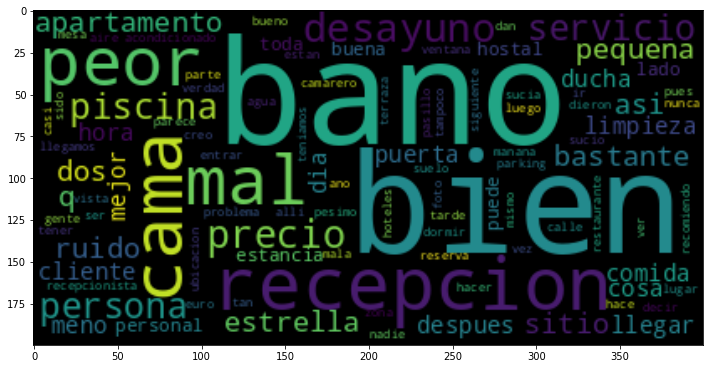

In [25]:
generate_wordcloud(df_negativo)

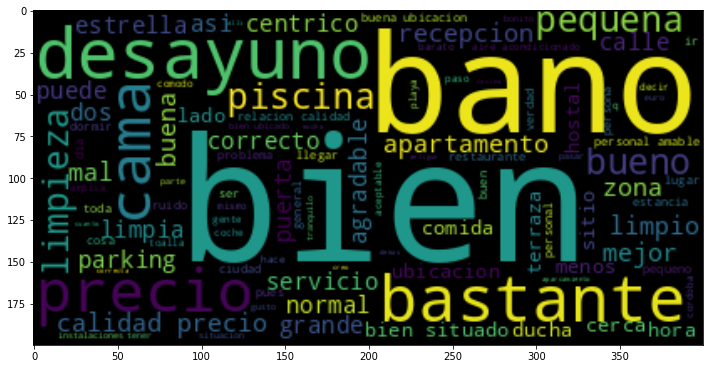

In [26]:
generate_wordcloud(df_neutro)

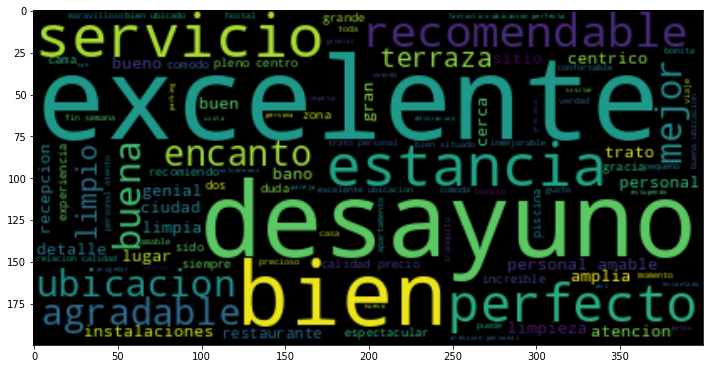

In [27]:
generate_wordcloud(df_positivo)

In [31]:
tfile = open('negativo.txt', 'a')
tfile.write(df_negativo['text_sin_stopwords'].to_string())
tfile.close()

In [32]:
tfile = open('neutro.txt', 'a')
tfile.write(df_neutro['text_sin_stopwords'].to_string())
tfile.close()

In [33]:
tfile = open('positivo.txt', 'a')
tfile.write(df_positivo['text_sin_stopwords'].to_string())
tfile.close()

In [35]:
model_negativo = fasttext.train_unsupervised('negativo.txt')
df_negativo['vec'] = df_negativo['text_sin_stopwords'].apply(lambda x: model_negativo.get_sentence_vector(x))

Read 0M words
Number of words:  709
Number of labels: 0
Progress: 100.0% words/sec/thread:   76904 lr:  0.000000 avg.loss:  3.150668 ETA:   0h 0m 0s


In [37]:
model_neutro = fasttext.train_unsupervised('neutro.txt')
df_neutro['vec'] = df_neutro['text_sin_stopwords'].apply(lambda x: model_neutro.get_sentence_vector(x))

Read 0M words
Number of words:  568
Number of labels: 0
Progress: 100.0% words/sec/thread:   65070 lr:  0.000000 avg.loss:  3.348999 ETA:   0h 0m 0s


In [38]:
model_positivo = fasttext.train_unsupervised('positivo.txt')
df_positivo['vec'] = df_positivo['text_sin_stopwords'].apply(lambda x: model_positivo.get_sentence_vector(x))

Read 0M words
Number of words:  519
Number of labels: 0
Progress: 100.0% words/sec/thread:   72910 lr:  0.000000 avg.loss:  3.279275 ETA:   0h 0m 0s


In [54]:
kmeans = KMeans(n_clusters=5)

In [55]:
df_negativo['cluster'] = kmeans.fit_predict(df_negativo['vec'].values.tolist())
df_neutro['cluster'] = kmeans.fit_predict(df_neutro['vec'].values.tolist())
df_positivo['cluster'] = kmeans.fit_predict(df_positivo['vec'].values.tolist())

In [56]:
df_negativo[df_negativo['cluster']==0]

,title,review_text,text,text_sin_stopwords,vec,cluster
14,Más errores que aciertos,"Una experiencia muy agridulce, por no decir pé...",mas errores que aciertos una experiencia muy a...,errores aciertos experiencia agridulce decir p...,"[-0.0040879073, 0.16223072, -0.053029735, 0.07...",0
18,No recomendado,Fuimos a una oposición y escogimos este hotel ...,no recomendado fuimos a una oposicion y escogi...,recomendado oposicion escogimos cercania prueb...,"[0.0035054015, 0.15470943, -0.05698207, 0.0716...",0
21,Mala experiencia personal,Ayre Seville Poco simpáticos y publicidad ine...,mala experiencia personal ayre seville poco s...,mala experiencia personal ayre seville simpati...,"[0.00032324376, 0.16279109, -0.05233072, 0.070...",0
28,El Hotel necesita muchas mejoras para las 4* q...,"Bastante decepcionada, suelo ir a hoteles de 4...",el hotel necesita muchas mejoras para las 4* q...,necesita muchas mejoras 4 * calidad precio inc...,"[0.0007011772, 0.16060202, -0.05321188, 0.0693...",0
34,No es un Barcelo,No tiene la calidad de la cadena Barcelo. El ...,no es un barcelo no tiene la calidad de la cad...,barcelo calidad cadena barcelo personal recepc...,"[0.0021319087, 0.16456315, -0.051115617, 0.077...",0
...,...,...,...,...,...,...
4913,"HORROROSO, IMPRESENTABLE, PARA NO VOLVER.","Hemos estado la semana pasada, y la verdad... ...",horroroso impresentable para no volver hemos e...,horroroso impresentable volver semana pasada v...,"[-0.0007947279, 0.15975408, -0.049543466, 0.07...",0
4914,INSPECCION DE LA JUNTA DE ANDALUCIA,Es una verguenza que hoteles de este tipo se e...,inspeccion de la junta de andalucia es una ver...,inspeccion junta andalucia verguenza hoteles t...,"[0.0032579692, 0.16202465, -0.05343179, 0.0728...",0
4923,"Pésimo, nada recomendable",Estuve con mi pareja en Septiembre de 2012 y n...,pesimo nada recomendable estuve con mi pareja ...,pesimo recomendable pareja septiembre 2012 que...,"[-0.00059979316, 0.16272971, -0.052056294, 0.0...",0
4927,Un hostal para no repetir,Nuestra estancia en este hostal fue para visit...,un hostal para no repetir nuestra estancia en ...,hostal repetir estancia hostal visitar fiesta ...,"[0.0005268079, 0.16094324, -0.054538406, 0.073...",0


In [51]:
df_negativo[df_negativo['cluster']==1]

,title,review_text,text,text_sin_stopwords,vec,cluster
15,Ruido insoportable de discoteca,Debajo de la habitación 304 hay una terraza de...,ruido insoportable de discoteca debajo de la h...,ruido insoportable discoteca debajo 304 terraz...,"[-0.00018781224, 0.15153863, -0.058036026, 0.0...",1
58,Decepcion,Fuimos a sevilla en el mes de agosto. La habit...,decepcion fuimos a sevilla en el mes de agosto...,decepcion mes agosto familiar genial limpieza ...,"[0.0035400956, 0.14756475, -0.048751637, 0.067...",1
113,"Hotel nuevo, en sitio bueno pero con pegas…",Hotel de nueva construcción con una ubicación ...,hotel nuevo en sitio bueno pero con pegas... h...,nuevo sitio bueno pegas ... nueva construccion...,"[0.0047055716, 0.14364716, -0.052920595, 0.055...",1
157,Poca colaboración,No se me ha permitido recibir en recepción un ...,poca colaboracion no se me ha permitido recibi...,poca colaboracion permitido recibir recepcion ...,"[0.0062820725, 0.14899924, -0.048103843, 0.066...",1
249,Un quiero y no puedo,"A ver, siendo objetiv@s la pensión no está mal...",un quiero y no puedo a ver siendo objetiv@s la...,quiero puedo ver siendo objetiv @ s pension ma...,"[0.0065841675, 0.14795259, -0.05367507, 0.0690...",1
...,...,...,...,...,...,...
4611,pilinguis,por favor k cambien esas fotos k son de el año...,pilinguis por favor k cambien esas fotos k son...,pilinguis favor k cambien fotos k ano quecos v...,"[0.024510482, 0.13440344, -0.051045842, 0.0500...",1
4645,no recomendable'frio en todos los sentidos,Lo venden como hotel con encanto y no es asi' ...,no recomendable'frio en todos los sentidos lo ...,recomendable'frio venden encanto asi ' frio ca...,"[0.0018080146, 0.14991046, -0.046024524, 0.063...",1
4750,no mola,"la recepcionita era nada agradable, somo 10, v...",no mola la recepcionita era nada agradable som...,mola recepcionita agradable somo 10 venimos aq...,"[0.012177907, 0.14684264, -0.04887121, 0.05739...",1
4833,inaudito y desastroso,El 27/02/2011 cuando llegamos a las 13:30 h. t...,inaudito y desastroso el 27/02/2011 cuando lle...,inaudito desastroso 27/02/2011 llegamos 1330 h...,"[-0.0034771254, 0.14572388, -0.04510745, 0.068...",1


In [53]:
df_negativo[df_negativo['cluster']==2]

,title,review_text,text,text_sin_stopwords,vec,cluster
18,No recomendado,Fuimos a una oposición y escogimos este hotel ...,no recomendado fuimos a una oposicion y escogi...,recomendado oposicion escogimos cercania prueb...,"[0.0035054015, 0.15470943, -0.05698207, 0.0716...",2
28,El Hotel necesita muchas mejoras para las 4* q...,"Bastante decepcionada, suelo ir a hoteles de 4...",el hotel necesita muchas mejoras para las 4* q...,necesita muchas mejoras 4 * calidad precio inc...,"[0.0007011772, 0.16060202, -0.05321188, 0.0693...",2
34,No es un Barcelo,No tiene la calidad de la cadena Barcelo. El ...,no es un barcelo no tiene la calidad de la cad...,barcelo calidad cadena barcelo personal recepc...,"[0.0021319087, 0.16456315, -0.051115617, 0.077...",2
39,Por una noche,Habitacion amplia pero algo sucia y mui viejo ...,por una noche habitacion amplia pero algo suci...,amplia sucia mui viejo precio 70 euros nocheba...,"[0.0038284548, 0.16097078, -0.04915283, 0.0702...",2
49,Una y no más.,"Para estar donde está, y la cadena que es... ...",una y no mas para estar donde esta y la caden...,cadena menuda depecion ser antiguo suelo moque...,"[0.0023983405, 0.15685436, -0.049773294, 0.074...",2
...,...,...,...,...,...,...
4906,no nos gusto nada,nos toco una habitacion con vistas a una pared...,no nos gusto nada nos toco una habitacion con ...,gusto toco vistas pared invernaderos pagar cam...,"[0.0033786837, 0.16249666, -0.051162183, 0.075...",2
4913,"HORROROSO, IMPRESENTABLE, PARA NO VOLVER.","Hemos estado la semana pasada, y la verdad... ...",horroroso impresentable para no volver hemos e...,horroroso impresentable volver semana pasada v...,"[-0.0007947279, 0.15975408, -0.049543466, 0.07...",2
4914,INSPECCION DE LA JUNTA DE ANDALUCIA,Es una verguenza que hoteles de este tipo se e...,inspeccion de la junta de andalucia es una ver...,inspeccion junta andalucia verguenza hoteles t...,"[0.0032579692, 0.16202465, -0.05343179, 0.0728...",2
4919,Muy caro para lo que ofrece,He estado alojada en el puente de mayo. La ubi...,muy caro para lo que ofrece he estado alojada ...,caro ofrece alojada puente mayo ubicacion buen...,"[-0.008743262, 0.15563534, -0.047825556, 0.065...",2
